### This script extract EEG signals based on the EMG signals, in order to align SEEG signals to the movement;

Input: Not re-referenced proprocessing1.mat from matlab. 

Output: trigger extracted from the EMG signals.



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gesture.config import *
import hdf5storage

2024-07-18 13:58:13 - Start Program

pre_all: Running from CMD.


In [1]:
from gesture.utils import sub_sf_dict

info_dict=sub_sf_dict()

2024-07-22 14:45:31 - Start Program

pre_all: Running from CMD.


In [2]:
sids=[int(i) for i in list(info_dict.keys())]
sid=sids[0]

data_folder = data_dir + 'preprocessing/' + 'P' + str(sid) + '/'
data_path = data_folder + 'preprocessing1.mat'
mat = hdf5storage.loadmat(data_path)
datas = mat['Datacell']
good_channels = mat['good_channels']
channelNum = len(np.squeeze(good_channels))
# channelNum=int(mat['channelNum'][0,0])
# total channel = channelNum + 4[2*emg + 1*trigger_indexes + 1*emg_trigger]
#data = np.concatenate((data[0, 0], data[0, 1]), 0)

In [4]:
info_dict

{'2': 1000,
 '3': 1000,
 '4': 1000,
 '5': 1000,
 '7': 1000,
 '8': 1000,
 '9': 1000,
 '10': 2000,
 '11': 500,
 '12': 500,
 '13': 2000,
 '14': 2000,
 '16': 2000,
 '17': 2000,
 '18': 2000,
 '19': 2000,
 '20': 1000,
 '21': 1000,
 '22': 2000,
 '23': 2000,
 '24': 2000,
 '25': 2000,
 '26': 2000,
 '29': 2000,
 '30': 2000,
 '31': 2000,
 '32': 2000,
 '34': 2000,
 '35': 1000,
 '41': 2000}

In [4]:
session=1
data=datas[0,session-1] # chn + emg1 +emg2 + emgdiff + trigger_label
BCIdata = data[:,:-4]
EMG=data[:,-4:-2]
EMGdiff=data[:,-2]
trigger_indexes = data[:,-1]

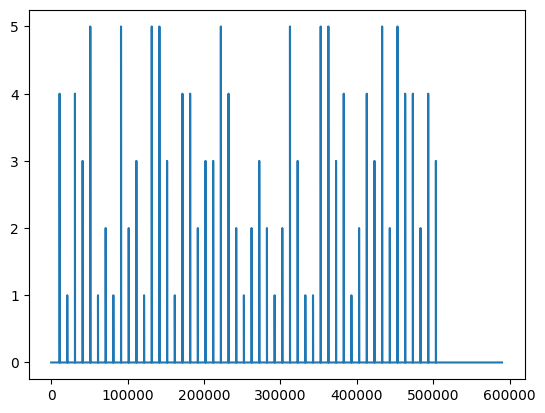

In [5]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(trigger_indexes)
plt.show()

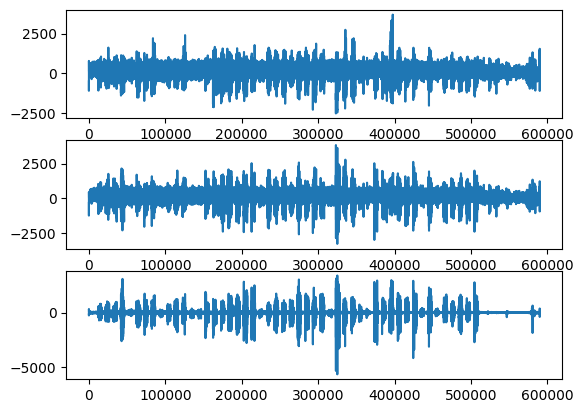

In [6]:
fig,ax=plt.subplots(3,1)
ax[0].plot(EMG[:,0])
ax[1].plot(EMG[:,1])
ax[2].plot(EMGdiff)
plt.show()

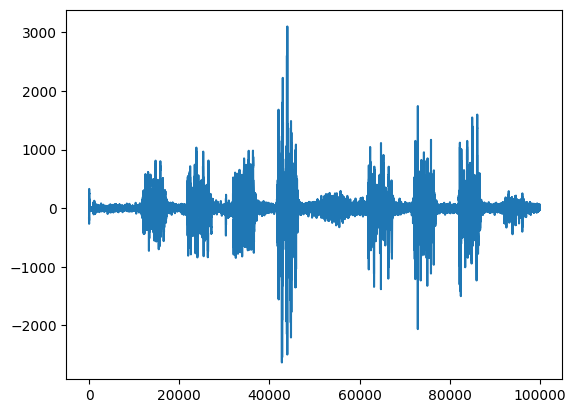

In [8]:
%matplotlib inline
#%matplotlib notebook
fig,ax=plt.subplots()
plt.plot(EMGdiff[:100000])
plt.show()

In [8]:
len(trigger_indexes)

590096

In [9]:
ch_types = ['eeg',]*BCIdata.shape[1]
ch_names = ['eeg'+str(i) for i in range(BCIdata.shape[1])]
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types=ch_types)
raw_eeg = mne.io.RawArray(BCIdata.transpose(), info)

In [10]:
ch_types = ['eeg']
ch_names = ['emgdiff']
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types=ch_types)
raw_emgdiff = mne.io.RawArray(EMGdiff[:,np.newaxis].transpose(), info)

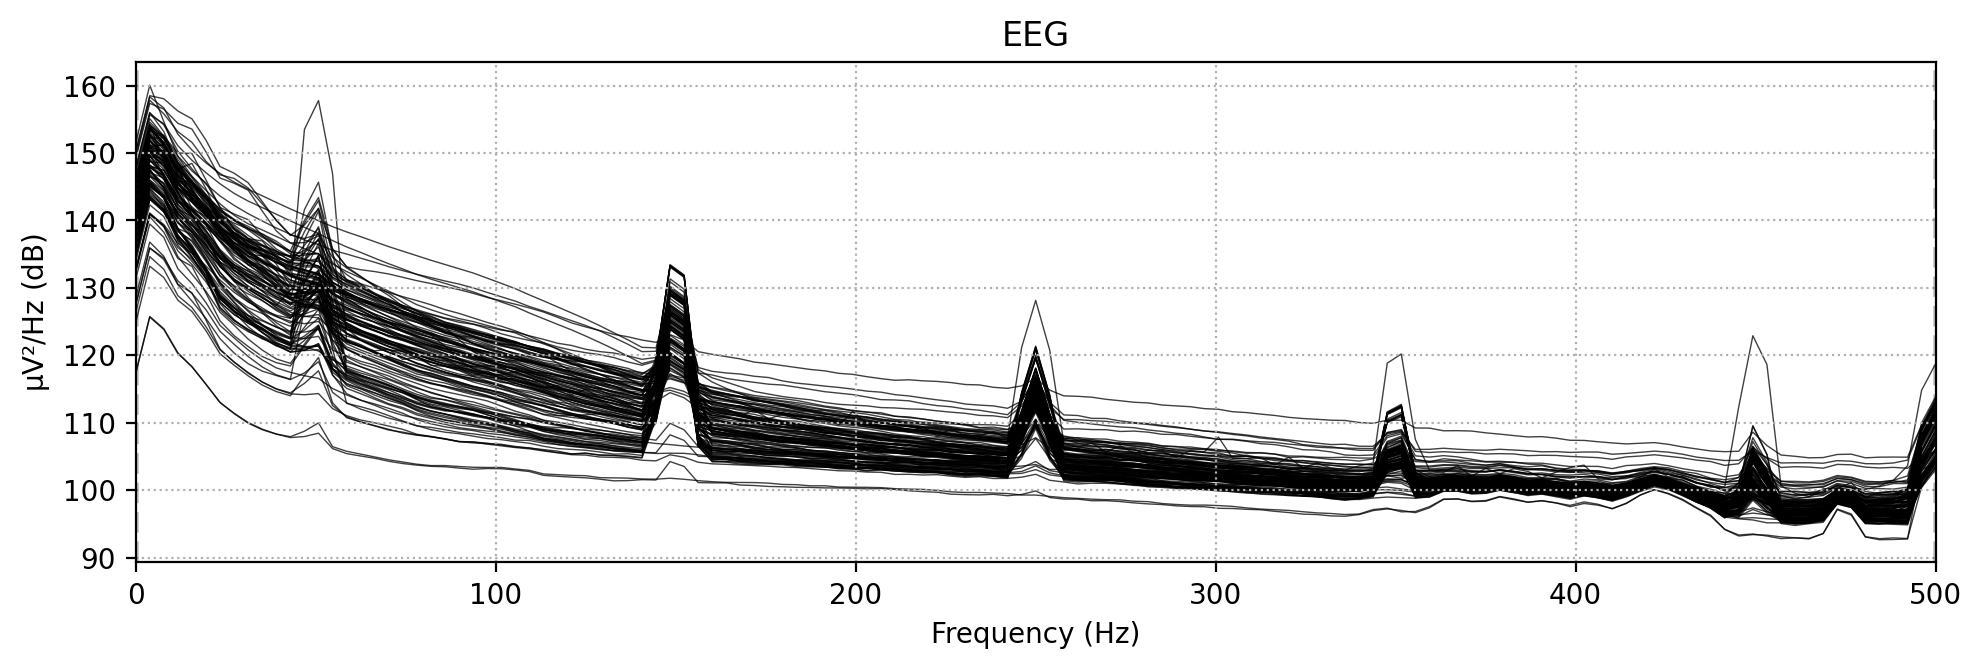

In [12]:
%matplotlib qt
raw_eeg.compute_psd().plot()

In [1]:
freqs = (50, 100, 150, 200, 250, 300, 350, 400, 450)
raw_eeg.notch_filter(freqs=freqs)
raw_eeg.compute_psd().plot()

NameError: name 'raw_eeg' is not defined

### Compute the envelope of the emgdiff

In [ ]:
emgdiff_env=raw_emgdiff.copy()
emgdiff_env.apply_hilbert(envelope=True)

<RawArray | 1 x 590096 (590.1 s), ~4.5 MB, data loaded>

In [ ]:
fig,ax=plt.subplots()
plt.plot(raw_emgdiff.get_data()[0,:])
plt.plot(emgdiff_env.get_data()[0,:])
plt.show()

<IPython.core.display.Javascript object>

### Hilbert should apply AFTER band pass filtering

Above plot showed component with low frequency and high amplitude, which should correspond to rhythmic hand movement. So, emgdiff should be highpassed, then computer the envelope.

In [ ]:
raw_emgdiff.compute_psd().plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
raw_emgdiff2=raw_emgdiff.copy()
emgdiff_env=raw_emgdiff.copy()
raw_emgdiff2.filter(l_freq=20, h_freq=None)
emgdiff_env.filter(l_freq=20, h_freq=None)

emgdiff_env.apply_hilbert(envelope=True)

%matplotlib notebook
fig,ax=plt.subplots(2,1)
ax[0].plot(raw_emgdiff2.get_data()[0,:])
ax[0].plot(emgdiff_env.get_data()[0,:])
ax[1].plot(raw_emgdiff2.get_data()[0,11600:13200])
ax[1].plot(emgdiff_env.get_data()[0,11600:13200])
plt.show()

<IPython.core.display.Javascript object>

### compare EMG and EEG trigger line: EEG triggers are ahead of EMG.

In [ ]:
from scipy.signal import savgol_filter
ind=np.where(trigger_indexes>0)
env_smooth = savgol_filter(emgdiff_env.get_data()[0,:], 200, 3) # window size 51, polynomial order 3
env_smooth_deriv=[]
for i in range(0,len(env_smooth)-1):
    #env_smooth_deriv.append(env_smooth[i]-2*env_smooth[i-1]+env_smooth[i-2])
    env_smooth_deriv.append(abs(env_smooth[i]-env_smooth[i-1]))
env_smooth_deriv.append(0)
fig,ax=plt.subplots()
ax.plot(raw_emgdiff2.get_data()[0,:])
ax.plot(emgdiff_env.get_data()[0,:])
ax.plot(env_smooth)
ax.plot([i*100 for i in env_smooth_deriv])
for i in ind[0]:
    ax.axvline(x=i)
ax.legend(['diff','diff_env','env_smooth','smooth_deriv_abs'],fontsize=5)
plt.show()

<IPython.core.display.Javascript object>

![](img/img1.png)

### Locate movement start from the EMG signals

In [ ]:
# based on the env_smooth (15)
ind_emg=[]
for i in ind[0]:
    j=0
    while True:
        if env_smooth_deriv[i+j]*100>50: # env_smooth not reliable for some places. env_smooth_deriv is better.
            ind_emg.append(i+j)
            break
        j=j+1

In [ ]:
fig,ax=plt.subplots()
ax.plot(raw_emgdiff2.get_data()[0,:])
ax.plot(emgdiff_env.get_data()[0,:])
ax.plot(env_smooth)
ax.plot([i*100 for i in env_smooth_deriv])
for i in ind[0]:
    ax.axvline(x=i,color='green',linestyle='-')
for i in ind_emg:
    ax.axvline(x=i,color='red',linestyle='--')
ax.legend(['diff','diff_env','env_smooth','smooth_deriv(abs)'],fontsize=5)
plt.show()

<IPython.core.display.Javascript object>

![](img/img2.png)

### create new trigger index based on the EMG trigger

In [ ]:
sequence=[int(i) for i in trigger_indexes if i != 0]
trigger_ind_emg=np.zeros(trigger_indexes.shape)
for i,j in enumerate(ind_emg):
    trigger_ind_emg[j]=sequence[i]
fig,ax=plt.subplots()
ax.plot(trigger_indexes,linestyle='-')
ax.plot(trigger_ind_emg,linestyle='--')
ax.legend(['trigger','trigger_emg'])
plt.show()

<IPython.core.display.Javascript object>

### combine all data into raw_all: raw_eeg(121),EMG(2),raw_emgdiff2(1),emgdiff_env(1),env_smooth_deriv(1),trigger_indexes(1),trigger_ind_emg(1)
channel number=EEG channels 121+7=128

In [ ]:
#raw_eeg.get_data()-(121, 590096),EMG-(590096, 2)
# ,raw_emgdiff2- (1, 590096),emgdiff_env-(1, 590096),env_smooth_deriv-(590096,),trigger_indexes-(590096,),trigger_ind_emg-(590096,)
data_all=np.concatenate((raw_eeg.get_data(),EMG.transpose(),raw_emgdiff2.get_data(),emgdiff_env.get_data(),
                         np.asarray(env_smooth_deriv)[np.newaxis,:],trigger_indexes[np.newaxis,:],trigger_ind_emg[np.newaxis,:]),axis=0)

In [ ]:
data_all.shape

(128, 590096)

In [ ]:
ch_types = ['eeg',]*len(raw_eeg.ch_names)+['misc',]*7
ch_names = ['eeg'+str(i) for i in range(len(raw_eeg.ch_names))]+['emg','emg','emg_diff','emg_diff_env','env_smooth_deriv','trigger_index','trigger_index_emg']
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types=ch_types)
raw_all = mne.io.RawArray(data_all, info)

In [ ]:
# save raw_all
filename=data_folder+'emg_trigger_raw.fif'
raw_all.save(filename)